In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN
import torch

In [1]:
def temperature(mass, energy, initial_temp):
    # if initial_temp == 0 then it is assumed to be ice
    # if initial_temp == 100 then it is assumed to be water
    specific_heat_ice = 0.5 # cal/(g*C)
    specific_heat_water = 1.0 # cal/(g*C)
    specific_heat_vapor = 0.48 # cal/(g*C)
    heat_of_fusion = 79.72 # cal/g
    heat_of_vaporization = 540 # cal/g
    
    curr_temp = initial_temp
    energy_left = energy
    if curr_temp < 0: # it's ice
        energy_needed_to_0 = - curr_temp * specific_heat_ice * mass
        if energy_needed_to_0 > energy_left:
            curr_temp += energy_left / (mass * specific_heat_ice)
            return curr_temp
        else:
            curr_temp = 0.0
            energy_left -= energy_needed_to_0
    if curr_temp == 0.0: # it's ice at 0 C
        energy_needed_to_water = heat_of_fusion * mass
        if energy_needed_to_water > energy_left:
            return curr_temp
        else:
            energy_left -= energy_needed_to_water
    if 0.0 <= curr_temp < 100.0: # it's water
        energy_needed_to_100 = (100.0 - curr_temp) * specific_heat_water * mass
        if energy_needed_to_100 > energy_left:
            curr_temp += energy_left / (mass * specific_heat_water)
            return curr_temp
        else:
            curr_temp = 100.0
            energy_left -= energy_needed_to_100
    if curr_temp == 100.0: # it's water at 100 C
        energy_needed_to_vapor = heat_of_vaporization * mass
        if energy_needed_to_vapor > energy_left:
            return curr_temp
        else:
            energy_left -= energy_needed_to_vapor
    if curr_temp >= 100.0: # it's vapor
        curr_temp += energy_left / (mass * specific_heat_vapor)
        return curr_temp
    
    # We should never get here
    return None

In [3]:
temperature(1, 3200, 0)

5267.250000000001

In [6]:
temperature(1,1,-100)

-98.0

In [ ]:
temperature

In [46]:
import pandas as pd
import numpy as np
generator = np.random.default_rng(0)

# ranges = {
# "mass":(1,10),
# "energy":(1,1000),
# "initial_temp":(-10,-9.5)
# }

n_samples = 1000
data = {}
data['energy_per_mass'] = generator.uniform(0,800,n_samples)
data['mass'] = generator.uniform(1,4,n_samples)
data['energy'] = data['energy_per_mass'] * data['mass']
data['initial_temp'] = generator.uniform(-100,0,n_samples)

# data = {k: generator.uniform(v[0],v[1],n_samples) for k,v in ranges.items()}
labels = [temperature(m,e,t) for m,e,t in zip(data['mass'],data['energy'],data['initial_temp'])]
data['temperature'] = labels
df = pd.DataFrame(data)

In [47]:
df.describe()

,energy_per_mass,mass,energy,initial_temp,temperature
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,413.525071,2.442766,1008.132679,-50.495297,85.293611
std,227.782558,0.887442,695.723066,28.623895,44.715296
min,0.152001,1.005752,0.378682,-99.967061,-93.901096
25%,219.055693,1.671654,448.665916,-74.245762,100.000000
50%,423.037840,2.401556,890.164139,-52.283576,100.000000
75%,611.359774,3.230452,1425.180665,-25.544753,100.000000
max,799.601082,3.994202,3058.360595,-0.044275,251.501939


<AxesSubplot: >

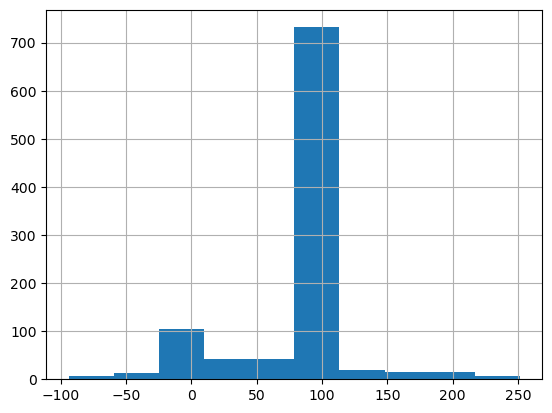

In [48]:
df['temperature'].hist()

In [51]:
generator = np.random.default_rng(0)

# ranges = {
# "mass":(1,10),
# "energy":(1,1000),
# "initial_temp":(-10,-9.5)
# }

n_samples = 10000
data = {}
# data['energy_per_mass'] = generator.uniform(0,800,n_samples)
data['mass'] = generator.uniform(1,4,n_samples)
data['energy'] = generator.uniform(1,3600,n_samples)
data['initial_temp'] = generator.uniform(-100,0,n_samples)
data['energy_per_mass'] = data['energy'] / data['mass']

# data = {k: generator.uniform(v[0],v[1],n_samples) for k,v in ranges.items()}
labels = [temperature(m,e,t) for m,e,t in zip(data['mass'],data['energy'],data['initial_temp'])]
data['temperature'] = labels
df = pd.DataFrame(data)

<AxesSubplot: >

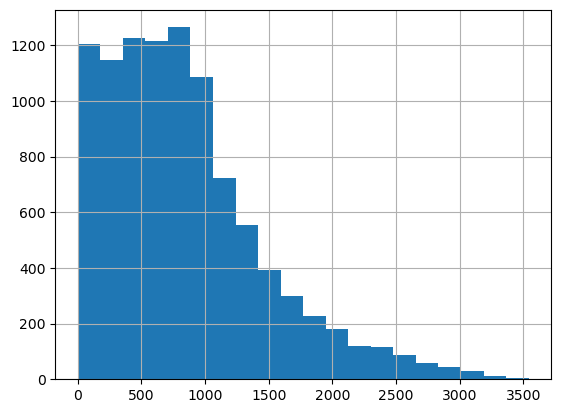

In [52]:
df['energy_per_mass'].hist(bins=20)

In [6]:
# df['energy_per_mass'] = (df['energy'] / df['mass'])
df['shifted'] = df['energy_per_mass'] + np.where(df['initial_temp'] < 0, 0.5*df['initial_temp'], df['initial_temp']+79.72)
df['temp_diff'] = df['temperature'] - df['initial_temp']
mask = (df['initial_temp'] > -2) & (df['initial_temp'] < 0)

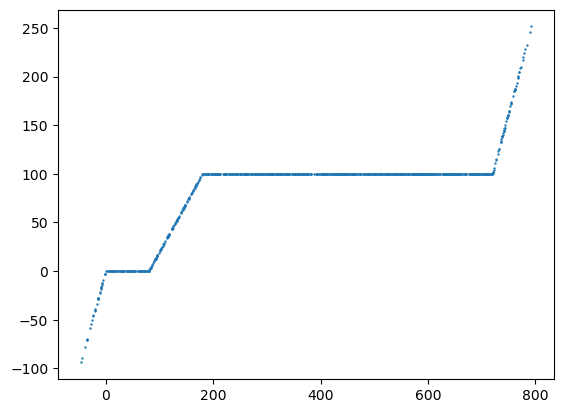

In [7]:
plt.scatter(data=df, x='shifted', y='temperature',s=0.5)
plt.show()

In [10]:
X = df[['mass','energy','initial_temp']].values
y = df['temperature'].values

task = 'regression'
global_seed = 0


gp_config = {
    'population_size':100,
    'generations':10,
    'function_set':('add','mul','div','shape'),
    'verbose':True,
    'random_state':global_seed,
    'const_range':None,
    'n_jobs':2,
    'p_crossover':0.55,
    'p_subtree_mutation':0.15,
    'p_point_mutation':0.15,
    'p_hoist_mutation':0.05,
    'p_point_replace':0.2,
    'parsimony_coefficient':0.0,
    'metric': ('mse' if task == 'regression' else 'log loss'),
    'parsimony_coefficient':0.0,
    'optim_dict': {
        'alg':'adam',
        'lr': 1e-2,
        'max_n_epochs':500,
        'tol':1e-5,
        'n_iter_no_change':10,
        'task':task,
        'device':'cuda',
        'batch_size':2000,
        'shape_class':[ShapeNN],
        'constructor_dict': [{
            'n_hidden_layers':10,
            'width':10,
            'activation_name':'ELU'
        }]
        }
    }
                           
# esr_parameter_dict = {
#     # 'parsimony_coefficient': scipy.stats()
#     'optim_dict': DictionaryDistribution({
#         'alg':['adam'],
#         'lr': scipy.stats.loguniform(1e-5,1),
#         'max_n_epochs':[200],
#         'tol':[1e-4],
#         'n_iter_no_change':[10],
#         'task':[task],
#         'device':['cuda'],
#         'batch_size':[20000]
#     })
# }

esr = SymbolicRegressor(**gp_config, categorical_variables={})

In [11]:
esr.fit(X,y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
Best program: shape(div(mul(shape(X2), shape(X0)), shape(X1)))
   0     5.90      1.97226e+09        9          316.556              N/A     40.82m
Best program: shape(add(div(shape(X1), shape(X0)), shape(X2)))
   1     7.25          1005.83        9          203.607              N/A     14.56m
Best program: shape(add(div(shape(X1), shape(X0)), shape(X2)))
   2     8.10          725.978        9          203.607              N/A      9.58m
Best program: shape(add(div(shape(X1), shape(X0)), shape(X2)))
   3     7.79          1089.05        9          203.607              N/A      6.21m
Best program: shape(add(div(shape(X1), shape(X0)), shape(X2)))
   4     7.64          952.451        9          203.607              N/A      1.65m
Best program: s

SymbolicRegressor(categorical_variables={}, const_range=None,
                  function_set=('add', 'mul', 'div', 'shape'), generations=10,
                  metric='mse', n_jobs=2,
                  optim_dict={'alg': 'adam', 'batch_size': 2000,
                              'device': 'cuda', 'lr': 0.01, 'max_n_epochs': 500,
                              'n_iter_no_change': 10, 'task': 'regression',
                              'tol': 1e-05},
                  p_crossover=0.55, p_hoist_mutation=0.05,
                  p_point_mutation=0.15, p_point_replace=0.2,
                  p_subtree_mutation=0.15, parsimony_coefficient=0.0,
                  population_size=100, random_state=0, verbose=True)

In [19]:
from gplearn.gplearn.functions import _function_map
from gplearn.gplearn.fitness import _fitness_map
from gplearn.gplearn.utils import check_random_state
from gplearn.gplearn._program import _Program

program_config = {
'function_set' : [_function_map['add'],_function_map['sub'],_function_map['mul'],_function_map['div'],_function_map['shape']],
'arities' : {1: [_function_map['shape']], 2: [_function_map['add'],_function_map['sub'],_function_map['mul'],_function_map['div']]},
'init_depth' : (2,5),
'init_method' : 'half and half',
'n_features' : 3,
'const_range' : None,
'metric' : _fitness_map['mse'],
'p_point_replace' : 0.2,
'parsimony_coefficient' : 0.0,
'random_state': check_random_state(global_seed),
'optim_dict': {
    'alg':'adam',
    'lr': 1e-2,
    'max_n_epochs':500,
    'tol':1e-5,
    'n_iter_no_change':10,
    'task':task,
    'device':'cuda',
    'batch_size':2000
    }
}

# for i in range(10):
#     program = _Program(**program_config)
#     print(program)

program_list = [_function_map['shape'],_function_map['add'],_function_map['div'],1,0,_function_map['shape'],2]
program = _Program(**program_config, program=program_list)

In [20]:
device = torch.device('cuda')
# params['ohe_matrices'] = self._create_ohe_matrices(X,self.categorical_variables, device=device)

X_t = torch.from_numpy(np.array(X)).float().to(device)
y_t = torch.from_numpy(np.array(y)).float().to(device)

In [21]:
program.raw_fitness(X_t,y_t,sample_weight=np.ones(X_t.shape[0]),ohe_matrices={})

shape(add(div(X1, X0), shape(X2)))
Did not converge in 500. Loss 215.53956604003906
Training: 19.145805835723877


215.32643400154706

In [ ]:
program.model.loss

In [12]:
program = esr._program
shapes = program.model.shape_functions

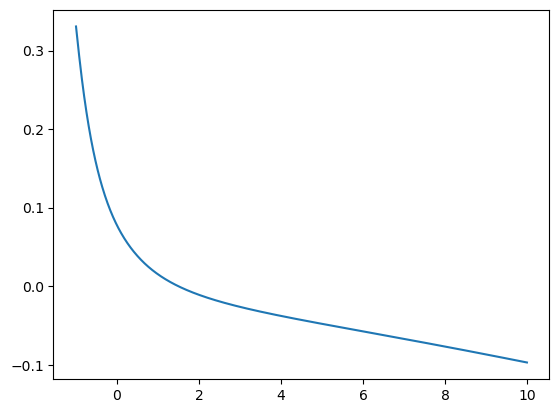

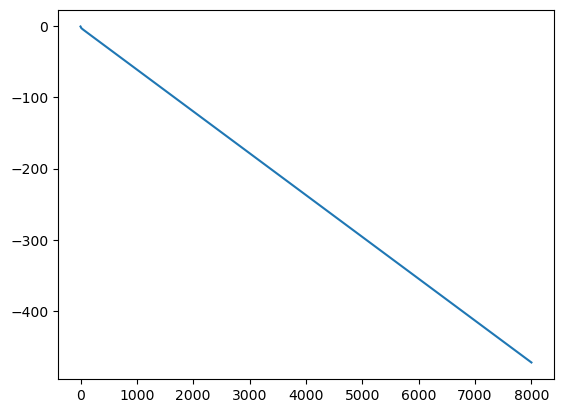

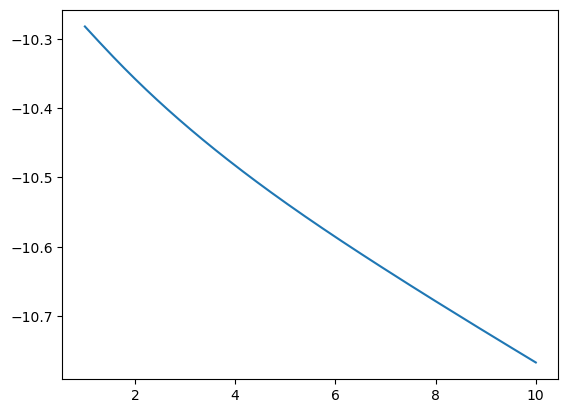

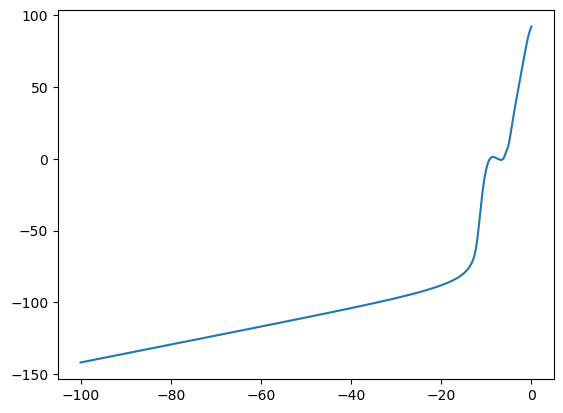

In [26]:

shapes.to(torch.device('cpu'))

t1 = torch.linspace(-1,10,1000)
plt.plot(t1.cpu().numpy(),shapes[0](t1.unsqueeze(1)).cpu().detach().numpy().flatten())
plt.show()
t2 = torch.linspace(0,8000,10000)
plt.plot(t2.cpu().numpy(),shapes[1](t2.unsqueeze(1)).cpu().detach().numpy().flatten())
plt.show()
t3 = torch.linspace(1,10,1000)
plt.plot(t3.cpu().numpy(),shapes[2](t3.unsqueeze(1)).cpu().detach().numpy().flatten())
plt.show()
t4 = torch.linspace(-100,0,10000)
plt.plot(t4.cpu().numpy(),shapes[3](t4.unsqueeze(1)).cpu().detach().numpy().flatten())
plt.show()

In [ ]:
from benchmarks import score

In [ ]:
score(esr,X,y,'regression')

In [ ]:
esr._program = program